<a href="https://colab.research.google.com/github/jacob7123/TensorFlow/blob/main/03_introduction_to_computer_vision_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Convolutional Neural Networks and Computer Vision with TensorFlow

Computer vision is the practice of writing algorithms which can discover patterns in visual data. Such as the camera of a self-driving car recognizing the car in front.

## Get the data

The images we are working with are from the Food101 dataset(101 different classes of food): https://www.kaggle.com/datasets/dansbecker/food-101

However we have modified it to only use two classes(pizza 🍕 and steak 🥩) using the image data modification notebook: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

> 🔑 **Note:** we start with a smaller dataset so we can experiment quickly and figure what works(or better yet what does not work) before scaling up.

In [1]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

--2024-01-17 06:16:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.207, 74.125.135.207, 172.253.117.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   217MB/s    in 0.5s    

2024-01-17 06:16:17 (217 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



## Inspect the data(become one with it)

A very curcil step at the beginning of any machine learning project is becoming one with data.

And for a computer vision project...this usually means visualizing many samples of your data.

In [2]:
!ls -la pizza_steak

total 16
drwxr-xr-x 4 root root 4096 Jan 17 06:16 .
drwxr-xr-x 1 root root 4096 Jan 17 06:16 ..
drwxr-xr-x 4 root root 4096 Jan 17 06:16 test
drwxr-xr-x 4 root root 4096 Jan 17 06:16 train


In [3]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'pizza_steak'.
There are 2 directories and 0 images in 'pizza_steak/train'.
There are 0 directories and 750 images in 'pizza_steak/train/steak'.
There are 0 directories and 750 images in 'pizza_steak/train/pizza'.
There are 2 directories and 0 images in 'pizza_steak/test'.
There are 0 directories and 250 images in 'pizza_steak/test/steak'.
There are 0 directories and 250 images in 'pizza_steak/test/pizza'.


In [4]:
# Another way to find out how many image are in a file
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))
num_steak_images_train

750

To visualize our images, first let's get the class names programmatically.

In [5]:
# Get the classnames programmatically
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Created a list of class_names from the subdirectories
print(class_names)


['pizza' 'steak']


In [6]:
# Let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Set the target directory(we will view images from here)
  target_folder = target_dir + target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  # Reading in the image and plot it using matplot
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image
  return img

['1761451.jpg']
Image shape: (384, 512, 3)


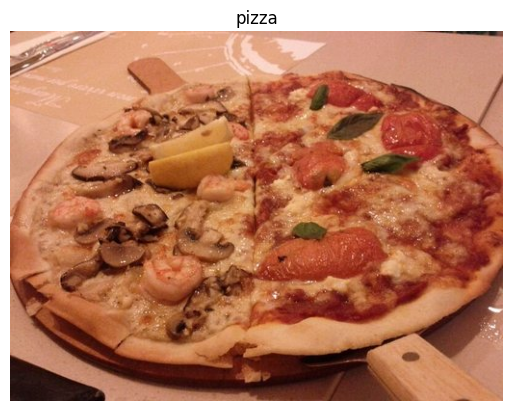

In [7]:
# View a random image from training dataset
img = view_random_image(target_dir="pizza_steak/train/",
             target_class="pizza")

In [8]:
# The images we have imported and ploted are actually giant array/tensors of different pixel values
import tensorflow as tf
tf.constant(img)

<tf.Tensor: shape=(384, 512, 3), dtype=uint8, numpy=
array([[[ 78,  22,   0],
        [ 84,  28,   5],
        [102,  46,  23],
        ...,
        [115,  81,  71],
        [119,  81,  70],
        [119,  81,  68]],

       [[132,  76,  53],
        [149,  93,  70],
        [174, 118,  95],
        ...,
        [119,  81,  72],
        [121,  81,  69],
        [121,  81,  69]],

       [[193, 135, 113],
        [206, 148, 126],
        [220, 162, 138],
        ...,
        [124,  81,  72],
        [126,  82,  71],
        [126,  82,  69]],

       ...,

       [[ 51,  30,  27],
        [ 48,  27,  24],
        [ 46,  25,  24],
        ...,
        [196, 135, 104],
        [195, 134, 105],
        [194, 134, 106]],

       [[ 53,  32,  29],
        [ 50,  29,  26],
        [ 48,  27,  26],
        ...,
        [202, 141, 110],
        [197, 136, 107],
        [194, 133, 104]],

       [[ 46,  25,  22],
        [ 44,  23,  20],
        [ 44,  23,  22],
        ...,
        [211, 148, 11

In [9]:
# View the image shape
img.shape # return width, height, color channels

(384, 512, 3)

> 🔑 **Note:** As we've discussed before, many machine learning models, including neural networks prefer the values they work with to be between 0 and 1. Knowing this, one of the most common preprocessing steps for working with images is to scale (also referred to as normalize) their pixel values by dividing the image arrays by 255.

In [10]:
# Get all the piexl values between 0 and 1
img/255.0

array([[[0.30588235, 0.08627451, 0.        ],
        [0.32941176, 0.10980392, 0.01960784],
        [0.4       , 0.18039216, 0.09019608],
        ...,
        [0.45098039, 0.31764706, 0.27843137],
        [0.46666667, 0.31764706, 0.2745098 ],
        [0.46666667, 0.31764706, 0.26666667]],

       [[0.51764706, 0.29803922, 0.20784314],
        [0.58431373, 0.36470588, 0.2745098 ],
        [0.68235294, 0.4627451 , 0.37254902],
        ...,
        [0.46666667, 0.31764706, 0.28235294],
        [0.4745098 , 0.31764706, 0.27058824],
        [0.4745098 , 0.31764706, 0.27058824]],

       [[0.75686275, 0.52941176, 0.44313725],
        [0.80784314, 0.58039216, 0.49411765],
        [0.8627451 , 0.63529412, 0.54117647],
        ...,
        [0.48627451, 0.31764706, 0.28235294],
        [0.49411765, 0.32156863, 0.27843137],
        [0.49411765, 0.32156863, 0.27058824]],

       ...,

       [[0.2       , 0.11764706, 0.10588235],
        [0.18823529, 0.10588235, 0.09411765],
        [0.18039216, 0

## An end-to-end example

Let's build a convolutional neural network to find patterns in our images, more specifically we need a way to:

* Load our images
* preprocess our image
* Build a CNN(Convolutional Neural Networks) to find patterns in our images
* Compile our CNN
* Fit the CNN to our training data

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set random seed
tf.random.set_seed(42)

# Preprocess data(get all of pixel values between 0 and 1, also call scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup paths to our data directories
train_dir = "/content/pizza_steak/train"
test_dir = "pizza_steak/test"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                         batch_size=32,
                         target_size=(224, 224),
                         class_mode="binary",
                         seed=42)
valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                         batch_size=32,
                         target_size=(224, 224),
                         class_mode="binary",
                         seed=42)

# Build a CNN model(same as the Tiny VGG on the CNN explainer website)
model_1 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=10,
              kernel_size=3,
              activation="relu",
              input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2,
               padding="valid"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile our CNN
model_1.compile(loss="binary_crossentropy", # we are training binary class(pizza and steak)
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
             epochs=5,
             steps_per_epoch=len(train_data),
             validation_data=valid_data,
             validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 20s 170ms/step - loss: 0.5235 - accuracy: 0.7360 - val_loss: 0.4185 - val_accuracy: 0.8040
Epoch 2/5
47/47 [==============================] - 7s 150ms/step - loss: 0.4342 - accuracy: 0.8080 - val_loss: 0.3662 - val_accuracy: 0.8380
Epoch 3/5
47/47 [==============================] - 6s 120ms/step - loss: 0.4288 - accuracy: 0.8053 - val_loss: 0.3640 - val_accuracy: 0.8440
Epoch 4/5
47/47 [==============================] - 7s 147ms/step - loss: 0.3727 - accuracy: 0.8353 - val_loss: 0.3248 - val_accuracy: 0.8580
Epoch 5/5
47/47 [==============================] - 6s 118ms/step - loss: 0.3162 - accuracy: 0.8673 - val_loss: 0.3352 - val_accuracy: 0.8480


In [12]:
# First run without GPU
# Epoch 1/5
# 47/47 [==============================] - 100s 2s/step - loss: 0.6054 - accuracy: 0.6913 - val_loss: 0.4604 - val_accuracy: 0.8180
# Epoch 2/5
# 47/47 [==============================] - 95s 2s/step - loss: 0.4426 - accuracy: 0.8073 - val_loss: 0.3780 - val_accuracy: 0.8420
# Epoch 3/5
# 26/47 [===============>..............] - ETA: 39s - loss: 0.4123 - accuracy: 0.8333

> 🔑 **Note:** If the above cell is taking longer than ~10 seconds per epoch, make sure you are using a GPU by going to Runtime -> Change Runtime Type -> Hardware Accelator -> GPU(you may have to rerun some cells above).

In [13]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                   

## Using the same model as before

Let's replicate the model we have built in a previous section to see if it works with ouur image data.

The model we are building is from the [TensorFlow playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=NaN&regularizationRate=0&noise=0&networkShape=4,4&seed=0.75075&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)


In [14]:
# Set the random seed
tf.random.set_seed(42)

# Create a model
model_2 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_2.compile(loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data,
             epochs=5,
             steps_per_epoch=len(train_data),
             validation_data=valid_data,
             validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 7s 111ms/step - loss: 2.9946 - accuracy: 0.5093 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 7s 141ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 5s 108ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 6s 138ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 5s 107ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000


In [15]:
# Get the summary of model_2
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                 602116    
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 602141 (2.30 MB)
Trainable params: 602141 (2.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Despite having 20x more parameters than our CNN(model_1), model_2 performs terribly... let's try to improve it.

In [16]:
# Set the random seed
tf.random.set_seed(42)

# Create a model(same as above but let's step it up a notch)
model_3 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid"),
])

# Compile the model
model_3.compile(loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(train_data,
             epochs=5,
             steps_per_epoch=len(train_data),
             validation_data=valid_data,
             validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 8s 133ms/step - loss: 2.3106 - accuracy: 0.6260 - val_loss: 1.1971 - val_accuracy: 0.5060
Epoch 2/5
47/47 [==============================] - 7s 142ms/step - loss: 1.0597 - accuracy: 0.6647 - val_loss: 0.7221 - val_accuracy: 0.7280
Epoch 3/5
47/47 [==============================] - 6s 128ms/step - loss: 0.7785 - accuracy: 0.7053 - val_loss: 0.7285 - val_accuracy: 0.6740
Epoch 4/5
47/47 [==============================] - 7s 140ms/step - loss: 0.7220 - accuracy: 0.7153 - val_loss: 0.5532 - val_accuracy: 0.7840
Epoch 5/5
47/47 [==============================] - 5s 116ms/step - loss: 0.5344 - accuracy: 0.7667 - val_loss: 0.4226 - val_accuracy: 0.7900


In [17]:
# Get a summary of model_3
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 100)               15052900  
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15073201 (57.50 MB)
Trainable params: 15073201 (57.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Binary Classification: Let's break it down

1. Become one with the data(visulize, visulize, visulize)
2. Preprocess the data(prepared it for our model, the main step here was scaling/normalizing)
3. Create a model(start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve the model(try to beat our baseline)
7. Repeat until satisfied(experiment, experiment, experiment)

### 1. Become one with the data

['3855584.jpg']
Image shape: (512, 512, 3)
['1828050.jpg']
Image shape: (307, 512, 3)


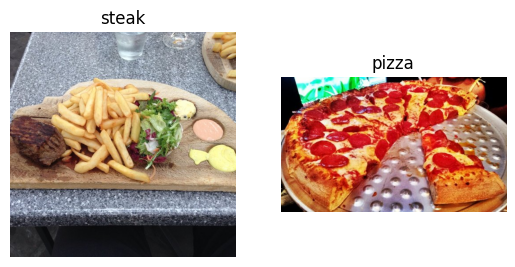

In [23]:
# Visulize data
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("pizza_steak/train/", "steak")
plt.subplot(1, 2, 2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")